## Numerical Methods In Finance | fall 2025


### *Test*

In [116]:
import sys
import numpy as np
import copy
from scipy.linalg import schur
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm

from typing import Union, Iterable
from scipy.interpolate import CubicSpline
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes import black_scholes
from py_vollib.black_scholes.implied_volatility import implied_volatility
implied_volatility_vectorized = np.vectorize(implied_volatility)




### 1. Salvaging a linear correlation matrix

You are given a correlation matrix estimated by the historical returns on the following underlyings **YDEX, SBER, T, USDRUB**:

$$\text{C} = \begin{pmatrix} 1 & 0.8 & 0.6 & -0.55 \\ 0.8 & 1 & 0.75 & -0.85 \\ 0.6 & 0.75 & 1 & -0.15 \\ -0.55 & -0.85 & -0.15 & 1 \end{pmatrix}$$

Unfortunately, this correlation matrix is not positive-semidefinite.

On the seminar you faced with two algorithms, based on **hypersphere** and **spectral** decompositions, providing the way on how to adjust a correlation matrix to make it positive-semidefinite. Each of these algorithms have their own pros and cons. Your task is to combine these approaches to construct the new and the best one.

Implement the following algorithm:

1. Apply a **spectral** decomposition algorithm, that is construct a symmetrix positive-definite matrix $\widetilde{\text{C}} = \text{B} \cdot \text{B}^T. $

2. Apply Cholesky decomposition to matrix $\widetilde{\text{C}} = \text{L} \cdot \text{L}^{T}$. 

3. Use matrix $\text{L}$ as an initial guess for the **hyphersphere** decomposition $\widetilde{\text{C}} = \text{B}' \cdot \text{B}'^T$ with reduced number of $\frac{n(n-1)}{2}$ angles, constructed with an optimization procedure.

Your answer should contatin the resulting matrix $\widetilde{\text{C}}$ and the $L_2$ norm between it and the original one. Does this combo-algorithm performs better than each of the algorithms separately?

### 1) Спектральное разложение

In [117]:

def truncate_negative_eigen_values(L: np.ndarray):
    L_ = copy.deepcopy(L)
    L_[np.diag_indices_from(L_)] = np.maximum(np.diag(L_), 1e-16)
    return L_

def scaling_matrix(Q: np.ndarray, L_: np.ndarray):
    return np.diag(1 / np.sum(Q * Q * np.diag(L_), axis=1))

def correlation_matrix_with_diag(Q: np.ndarray, T: np.ndarray, L_: np.ndarray):
    B = np.sqrt(T) @ Q @ np.sqrt(np.abs(L_))
    C = B @ B.T
    # for i in range(len(C)):
    #     C[i][i] = 1
    return C

C = np.array([
    [ 1.00,  0.80,  0.60, -0.55],
    [ 0.80,  1.00,  0.75, -0.85],
    [ 0.60,  0.75,  1.00, -0.15],
    [-0.55, -0.85, -0.15,  1.00]
])

L_schur, Q = schur(C)
L_truncated = truncate_negative_eigen_values(L_schur)
T_scale = scaling_matrix(Q, L_truncated)
C_spec = correlation_matrix_with_diag(Q, T_scale, L_truncated)


eigvals = np.diag(L_schur)
# print("Diagonal matrix L from Schur decomposition: \n {} \n".format(L_schur))
# print("Unitary matrix Q from Schur decomposition: \n {} \n".format(Q))
# print("Q x Q^T: \n {} \n".format(Q @ Q.T))
print("Initial matrix C: \n {} \n".format(C))
print("Reconstructed from Schur decomposition matrix Q x L x Q^T: \n {} \n".format(Q @ L_schur @ Q.T))



dist_spec_fro = np.linalg.norm(C_spec - C, ord="fro")
dist_spec_l2 = np.linalg.norm(C_spec - C, ord=2)
print("dist_spec_fro = ", dist_spec_fro)
print("dist_spec_l2 = " , dist_spec_l2)

print("Eigen values of initial symmetric matrix C: \n {} \n".format(np.linalg.eig(C).eigenvalues))
print("Eigen values of positive-definite matrix constructed via spec: \n {} \n".format(np.linalg.eig(C_spec).eigenvalues))



Initial matrix C: 
 [[ 1.    0.8   0.6  -0.55]
 [ 0.8   1.    0.75 -0.85]
 [ 0.6   0.75  1.   -0.15]
 [-0.55 -0.85 -0.15  1.  ]] 

Reconstructed from Schur decomposition matrix Q x L x Q^T: 
 [[ 1.    0.8   0.6  -0.55]
 [ 0.8   1.    0.75 -0.85]
 [ 0.6   0.75  1.   -0.15]
 [-0.55 -0.85 -0.15  1.  ]] 

dist_spec_fro =  0.08766382540184617
dist_spec_l2 =  0.0656354176673492
Eigen values of initial symmetric matrix C: 
 [ 2.89541676  0.8579575   0.31047399 -0.06384826] 

Eigen values of positive-definite matrix constructed via spec: 
 [2.84500798e+00 8.46285679e-01 3.08706344e-01 1.55828130e-16] 



### 2) Гиперсферическая параметризация

$$\text{B}' = \begin{pmatrix}
1 & 0 & 0 & 0 \\
\cos(\theta_{21}) & \sin(\theta_{21}) & 0 & 0 \\
\cos(\theta_{31}) & \sin(\theta_{31})\cos(\theta_{32}) & \sin(\theta_{31})\sin(\theta_{32}) & 0 \\
\cos(\theta_{41}) & \sin(\theta_{41})\cos(\theta_{42}) & \sin(\theta_{41})\sin(\theta_{42})\cos(\theta_{43}) & \sin(\theta_{41})\sin(\theta_{42})\sin(\theta_{43})
\end{pmatrix}$$

In [118]:
def generate_B_reduced(theta):
    """Строит нижнетреугольную матрицу B (6 углов)"""
    t21, t31, t32, t41, t42, t43 = theta
    B = np.zeros((4, 4))
    
    B[0, 0] = 1.0
    
    B[1, 0] = np.cos(t21)
    B[1, 1] = np.sin(t21)
    
    B[2, 0] = np.cos(t31)
    B[2, 1] = np.cos(t32) * np.sin(t31)
    B[2, 2] = np.sin(t31) * np.sin(t32)
    
    B[3, 0] = np.cos(t41)
    B[3, 1] = np.cos(t42) * np.sin(t41)
    B[3, 2] = np.cos(t43) * np.sin(t41) * np.sin(t42)
    B[3, 3] = np.sin(t41) * np.sin(t42) * np.sin(t43)
    return B

def generate_B_full(theta):
    """Строит полную матрицу B (12 углов)"""
    theta_mat = np.asarray(theta).reshape(4, 3)
    B = np.zeros((4, 4))
    for i in range(4):
        B[i, 0] = np.cos(theta_mat[i, 0])
        sin_prod_1 = np.sin(theta_mat[i, 0])
        B[i, 1] = np.cos(theta_mat[i, 1]) * sin_prod_1

        sin_prod_2 = sin_prod_1 * np.sin(theta_mat[i, 1])
        B[i, 2] = np.cos(theta_mat[i, 2]) * sin_prod_2

        sin_prod_3 = sin_prod_2 * np.sin(theta_mat[i, 2])
        B[i, 3] = sin_prod_3

    return B

def recover_theta_from_L(L):
    """Извлекает 6 углов theta из матрицы L"""
    theta = np.zeros(6)
    theta[0] = np.arccos(L[1, 0])
    theta[1] = np.arccos(L[2, 0])
    theta[2] = np.arccos(L[2, 1] / np.sin(theta[1]))
    theta[3] = np.arccos(L[3, 0])
    theta[4] = np.arccos(L[3, 1] / np.sin(theta[3]))
    
    denom = np.sin(theta[3]) * np.sin(theta[4])
    theta[5] = np.arccos(L[3, 2] / denom)
    return theta

In [119]:
def fro_norm(A, B):
    return np.linalg.norm(A - B, ord='fro')

def l2_norm(A, B):
    return np.linalg.norm(A - B, ord=2)

# спектральный метод
L_schur, Q = schur(C)
L_tr = truncate_negative_eigen_values(L_schur)
T_mat = scaling_matrix(Q, L_tr)
C_spec = correlation_matrix_with_diag(Q, T_mat, L_tr)

# гиперсферический
res_full = minimize(lambda t, c: fro_norm(generate_B_full(t) @ generate_B_full(t).T, c), x0=np.random.rand(12), args=(C,), method="BFGS")
# res_full = minimize(lambda t, c: l2_norm(generate_B_full(t) @ generate_B_full(t).T, c), x0=np.random.rand(12), args=(C,), method="BFGS")
C_full = generate_B_full(res_full.x) @ generate_B_full(res_full.x).T

# комбинированный
L_chol = np.linalg.cholesky(C_spec)
theta_init = recover_theta_from_L(L_chol)
res_combo = minimize(lambda t, c: fro_norm(generate_B_reduced(t) @ generate_B_reduced(t).T, c), x0=theta_init, args=(C,), method="BFGS")
# res_combo = minimize(lambda t, c: l2_norm(generate_B_reduced(t) @ generate_B_reduced(t).T, c), x0=theta_init, args=(C,), method="BFGS")

# print("Optimal θ_opt: \n {} \n".format(res_combo.x))
C_combo = generate_B_reduced(res_combo.x) @ generate_B_reduced(res_combo.x).T

In [120]:
results = []

results.append({
    "Method": "Spectral Only",
    "Fro": fro_norm(C_spec, C),
    "L2": l2_norm(C_spec, C),
    "Iters": 0 
})

results.append({
    "Method": "Full Hypersphere",
    "Fro": fro_norm(C_full, C),
    "L2": l2_norm(C_full, C),
    "Iters": res_full.nit
})

results.append({
    "Method": "Combined (Combo)",
    "Fro": fro_norm(C_combo, C),
    "L2": l2_norm(C_combo, C),
    "Iters": res_combo.nit
})

print(f"{'Алгоритм':<20} | {'Frobenius':<16} | {'L2 Norm':<16} | {'Итерации'}")
print("-" * 65)
for r in results:
    print(f"{r['Method']:<20} | {r['Fro']:.15f}   | {r['L2']:.15f}   | {r['Iters']}")

print("\n\n initial matrix:\n ", C)
print("\n\n approx matrix:\n ", C_combo)


Алгоритм             | Frobenius        | L2 Norm          | Итерации
-----------------------------------------------------------------
Spectral Only        | 0.087663825401846   | 0.065635417667349   | 0
Full Hypersphere     | 0.083687952914375   | 0.067399794610098   | 18
Combined (Combo)     | 0.083687953130603   | 0.067399780105956   | 7


 initial matrix:
  [[ 1.    0.8   0.6  -0.55]
 [ 0.8   1.    0.75 -0.85]
 [ 0.6   0.75  1.   -0.15]
 [-0.55 -0.85 -0.15  1.  ]]


 approx matrix:
  [[ 1.          0.7934823   0.6035207  -0.55428924]
 [ 0.7934823   1.          0.71571834 -0.8082345 ]
 [ 0.6035207   0.71571834  1.         -0.17256047]
 [-0.55428924 -0.8082345  -0.17256047  1.        ]]


In [121]:
best_fro = np.linalg.norm(C_combo - C, 'fro')
# best_fro = np.linalg.norm(C_combo - C, ord = 2)

best_l2  = np.linalg.norm(C_combo - C, 2)

print(f"{'Алгоритм':<20} | {'Frobenius ':<17} | {'L2 Norm ':<17} | {'Итерации'}")
print("-" * 85)

# 1. Spectral
f1 = dist_spec_fro
l1 = dist_spec_l2
print(f"{'1. Spectral':<20} | {f1:.15f} | {l1:.15f} | 0")

# 2. Hypersphere
f2 = np.linalg.norm(C_full - C, 'fro')
l2 = np.linalg.norm(C_full - C, 2)
print(f"{'2. Hypersphere':<20} | {f2:.15f} | {l2:.15f} | {res_full.nit}")

# 3. Combined
f3 = np.linalg.norm(C_combo - C, 'fro')
l3 = np.linalg.norm(C_combo - C, 2)
print(f"{'3. Combined':<20} | {f3:.15f} | {l3:.15f} | {res_combo.nit}")

# print(f"Разница Frobenius (Spectral - Combined):    {f1 - f3:+.15f}")
# print(f"Разница Frobenius (Hypersphere - Combined): {f2 - f3:+.15f}")
# print("-" * 85)
# print(f"Разница L2 Norm (Spectral - Combined):       {l1 - l3:+.15f}")
# print(f"Разница L2 Norm (Hypersphere - Combined):    {l2 - l3:+.15f}")

# eigen values 
# print("Eigen values of initial symmetric matrix C: \n {} \n".format(np.linalg.eig(C).eigenvalues))
# print("Eigen values of positive-definite matrix constructed via combo: \n {} \n".format(np.linalg.eig(C_combo).eigenvalues))

Алгоритм             | Frobenius         | L2 Norm           | Итерации
-------------------------------------------------------------------------------------
1. Spectral          | 0.087663825401846 | 0.065635417667349 | 0
2. Hypersphere       | 0.083687952914375 | 0.067399794610098 | 18
3. Combined          | 0.083687953130603 | 0.067399780105956 | 7


### 2. Monte-Carlo integration

Having constructed the positive-semidefintie correlation matrix, you need to use it to price a basket option on **YDEX** and **SBER**.

The payoff of your option at expiration $T$ is 

$$\text{Payoff}(S^{YDES}_T, S^{SBER}_T) = \left(\frac{1}{2} \left(\frac{S^{YDEX}_T}{S^{YDEX}_0} + \frac{S^{SBER}_T}{S^{SBER}_0}\right) - 100\% \right)_{+}.$$

Assume that each stock evolves as a geometric Brownian motion:

$$S^{YDEX}_T = S^{YDEX}_0 e^{(r - (\sigma^{YDEX})^2/2)T + \sigma^{YDEX} W^{YDEX}_T}, \quad S^{SBER}_T = S^{SBER}_0 e^{(r - (\sigma^{SBER})^2/2)T + \sigma^{SBER} W^{SBER}_T},$$

where $W^{YDEX}_T$ and $W^{SBER}_T$ are Brownian motions correlated with $\rho^{YDEX, SBER}$. 

The price of the option can be expressed as the following expectation

$$P = e^{-rT} \cdot \mathbb{E}^{\mathbb{Q}} [\text{Payoff}(S^{SBER}_T, S^{MGNT}_T)],$$

wich can be evaluated using Monte-Carlo algorithm.

You may assume that risk-free interest rate $r = 16.5\%$, the initial stock prices are $S^{YDEX}_0 = 3050$, $S^{SBER}_0 = 290$ and the volatilities are $\sigma^{YDEX}_0 = 25\%$, $\sigma^{SBER}_0 = 22\%$. The maturity of the option $T$ is equal to on year.

Your answer should contatin the plot of the price $P$ of the option as a function on number of Monte-Carlo simulations $N$. Does your algorithm converges? What is the speed of the convergence as a function of $N$? Plot the graph of the speed of convergence as a function of $N$. 

In [122]:
S0_YDEX = 3050.0
S0_SBER = 290.0
r = 0.165         
T = 1.0           
sigma_YDEX = 0.25 
sigma_SBER = 0.22 


C_approx = C_combo
rho = C_approx[0, 1] 
Sigma_2d = np.array([[1.0, rho], [rho, 1.0]])


In [123]:
# L * L.T = [[1, rho], [rho, 1]]
L_2d = np.array([
    [1.0, 0.0],
    [rho, np.sqrt(1 - rho**2)]
])

print("\n Матрица L:")
print(L_2d)


 Матрица L:
[[1.         0.        ]
 [0.7934823  0.60859333]]


In [124]:
def sample_independent_uniform_variates(n_sample: int, size: int = 1, random_seed: int = 42):
    """Генерация независимых равномерных случайных величин"""
    np.random.seed(random_seed)
    return np.random.rand(n_sample, size)

def transform_uniform_to_gaussian(uniform_sample: np.ndarray):
    """Перевод равномерных величин в стандартные нормальные (Inverse Transform)"""
    return norm.ppf(uniform_sample)

def transform_gaussian_to_uniform(gaussian_sample: np.ndarray):
    """Перевод нормальных величин обратно в равномерные (CDF)"""
    return norm.cdf(gaussian_sample)

def generate_gaussian_copula_samples(n_sample: int, corr_matrix: np.ndarray, seed: int = 42):
    """
    Генерация зависимых равномерных величин с использованием Гауссовской копулы.
    Алгоритм:
    1. Генерируем независимые равномерные U_ind.
    2. Переводим в независимые нормальные Z_ind.
    3. Коррелируем их с помощью Холецкого: Z_corr = Z_ind @ L.T.
    4. Переводим обратно в равномерные: U_corr = CDF(Z_corr).
    """
    size = corr_matrix.shape[0]
    
    # 1. Independent Uniform
    U_ind = sample_independent_uniform_variates(n_sample, size, seed)
    
    # 2. Independent Gaussian
    Z_ind = transform_uniform_to_gaussian(U_ind)
    
    # 3. Correlated Gaussian
    # Используем разложение Холецкого для матрицы корреляций
    L = np.linalg.cholesky(corr_matrix)
    Z_corr = Z_ind @ L.T
    
    # 4. Correlated Uniform (Copula samples)
    U_corr = transform_gaussian_to_uniform(Z_corr)
    
    return U_corr

def generate_gaussian_copula_samples_gauss(n_sample: int, corr_matrix: np.ndarray, seed: int = 42):
    """
    Генерация зависимых гауссовских величин с использованием Гауссовской копулы.
    Алгоритм:
    1. Генерируем независимые равномерные U_ind.
    2. Переводим в независимые нормальные Z_ind.
    3. Коррелируем их с помощью Холецкого: Z_corr = Z_ind @ L.T.
    4. Переводим обратно в равномерные: U_corr = CDF(Z_corr).
    """
    size = corr_matrix.shape[0]
    
    # 1. Independent Uniform
    U_ind = sample_independent_uniform_variates(n_sample, size, seed)
    
    # 2. Independent Gaussian
    Z_ind = transform_uniform_to_gaussian(U_ind)
    
    # 3. Correlated Gaussian
    # Используем разложение Холецкого для матрицы корреляций
    L = np.linalg.cholesky(corr_matrix)
    Z_corr = Z_ind @ L.T
    
    
    return Z_corr

In [125]:
def get_stock_prices_from_uniform(U, S0, r, sigma, T):
    """
    Преобразование равномерной величины U ~ Uniform[0,1] в цену акции S_T 
    через обратную функцию распределения (Inverse CDF).
    
    Для Geometric Brownian Motion:
    ln(S_T) ~ N( ln(S0) + (r - 0.5*sigma^2)*T,  sigma^2 * T )
    
    S_T = F^{-1}(U) = S0 * exp( (r - 0.5*sigma^2)*T + sigma*sqrt(T) * NormPPF(U) )
    """
    standard_normal_quantile = norm.ppf(U)
    
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * standard_normal_quantile
    
    S_T = S0 * np.exp(drift + diffusion)
    return S_T

def get_stock_prices(Z, S0, r, sigma, T):
    """Расчет цены акции по формуле GBM на основе нормальной величины Z"""
    drift = (r - 0.5 * sigma**2) * T
    diffusion = sigma * np.sqrt(T) * Z
    return S0 * np.exp(drift + diffusion)



def calculate_basket_payoff(S1_T, S2_T, S1_0, S2_0):
    """Выплата по опциону Basket"""
    # Payoff = ( 0.5 * (S1/S1_0 + S2/S2_0) - 100% )_+
    performance = 0.5 * (S1_T / S1_0 + S2_T / S2_0)
    return np.maximum(performance - 1.0, 0.0)

def price_option_monte_carlo(n_sims, corr_matrix_2d, S1_0, S2_0, r, T, sigma1, sigma2, seed=42):
    """Полный цикл оценки опциона методом Монте-Карло с Гауссовской копулой"""
    
    # 1. Генерируем зависимые равномерные величины (сэмплы из копулы)
    U_corr = generate_gaussian_copula_samples(n_sims, corr_matrix_2d, seed)
    
    # 2. Переходим к маргинальным распределениям (Цены акций)
    # U_corr[:, 0] -> YDEX, U_corr[:, 1] -> SBER
    S1_T = get_stock_prices_from_uniform(U_corr[:, 0], S1_0, r, sigma1, T)
    S2_T = get_stock_prices_from_uniform(U_corr[:, 1], S2_0, r, sigma2, T)
    
    payoffs = calculate_basket_payoff(S1_T, S2_T, S1_0, S2_0)
    
    discount_factor = np.exp(-r * T)
    price = discount_factor * np.mean(payoffs)
    
    return price

def price_option_monte_carlo2(n_sims, corr_matrix_2d, S1_0, S2_0, r, T, sigma1, sigma2, seed=42):
    # Получаем коррелированные нормальные (начав с равномерных)
    Z = generate_gaussian_copula_samples_gauss(n_sims, corr_matrix_2d, seed)
    
    S1_T = get_stock_prices(Z[:, 0], S1_0, r, sigma1, T)
    S2_T = get_stock_prices(Z[:, 1], S2_0, r, sigma2, T)
    
    payoffs = np.maximum(0.5 * (S1_T / S1_0 + S2_T / S2_0) - 1.0, 0.0)
    
    return np.exp(-r * T) * np.mean(payoffs)


In [126]:
final_estimate = price_option_monte_carlo2(10**6, Sigma_2d, S0_YDEX, S0_SBER, r, T, sigma_YDEX, sigma_SBER, seed=42)
print(f"Финальная оценка : {final_estimate:.6f}")

powers = np.arange(1, 20)
n_simulations_list = 2**powers
prices = []
abs_errors = []

for n in n_simulations_list:
    p = price_option_monte_carlo2(n, Sigma_2d, S0_YDEX, S0_SBER, r, T, sigma_YDEX, sigma_SBER, seed=42)
    prices.append(p)
    abs_errors.append(np.abs(p - final_estimate))
    print(f"N={n:8d}, Price={p:.6f}, Error={np.abs(p - final_estimate):.6e}")

Финальная оценка : 0.179173
N=       2, Price=0.227649, Error=4.847598e-02
N=       4, Price=0.113824, Error=6.534851e-02
N=       8, Price=0.120124, Error=5.904885e-02
N=      16, Price=0.094440, Error=8.473293e-02
N=      32, Price=0.139942, Error=3.923069e-02
N=      64, Price=0.155330, Error=2.384292e-02
N=     128, Price=0.170438, Error=8.734522e-03
N=     256, Price=0.179416, Error=2.425224e-04
N=     512, Price=0.167029, Error=1.214420e-02
N=    1024, Price=0.178304, Error=8.693056e-04
N=    2048, Price=0.177402, Error=1.771397e-03
N=    4096, Price=0.173492, Error=5.680553e-03
N=    8192, Price=0.176201, Error=2.972232e-03
N=   16384, Price=0.178341, Error=8.319374e-04
N=   32768, Price=0.178533, Error=6.398349e-04
N=   65536, Price=0.178042, Error=1.131126e-03
N=  131072, Price=0.179537, Error=3.644710e-04
N=  262144, Price=0.178976, Error=1.966554e-04
N=  524288, Price=0.179427, Error=2.542640e-04


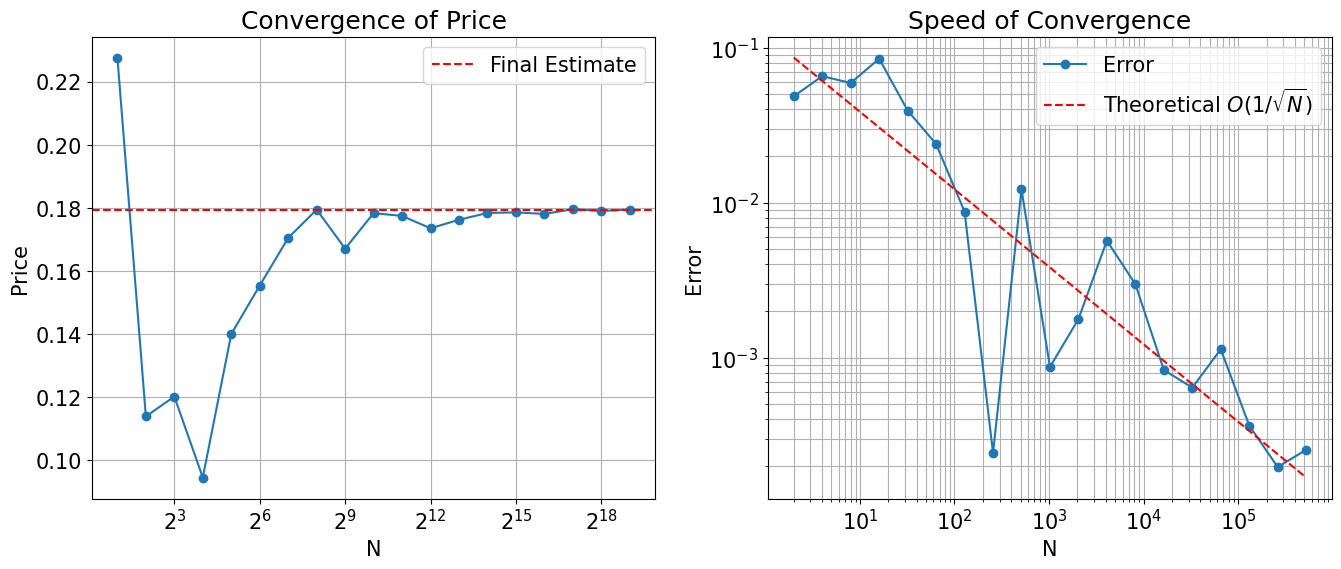

In [127]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(n_simulations_list, prices, 'o-')
plt.axhline(y=final_estimate, color='r', linestyle='--', label='Final Estimate')
plt.xscale('log', base=2)
plt.xlabel('N')
plt.ylabel('Price')
plt.title('Convergence of Price')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.loglog(n_simulations_list, abs_errors, 'o-', label='Error')

# Theoretical 1/sqrt(N)
# ln(C) ≈ ln(Error) + 0.5*ln(N)
C_fit = np.exp(np.mean(np.log(abs_errors) + 0.5 * np.log(n_simulations_list)))
theoretical_line = C_fit / np.sqrt(n_simulations_list)

plt.loglog(n_simulations_list, theoretical_line, 'r--', label=r'Theoretical $O(1/\sqrt{N})$')
plt.xlabel('N')
plt.ylabel('Error')
plt.title('Speed of Convergence')
plt.legend()
plt.grid(True, which="both")

plt.show()

In [128]:
log_N = np.log(n_simulations_list)
log_err = np.log(abs_errors)

slope, intercept = np.polyfit(log_N, log_err, 1)
theoretical_slope = -0.5

print(f"theoretical slope:  {theoretical_slope:.4f}")
print(f"fact slopeклон:     {slope:.4f}")
print(f"diff:               {abs(slope - theoretical_slope):.4f}")

theoretical slope:  -0.5000
fact slopeклон:     -0.4760
diff:               0.0240


### 3. Implied volatilities interpolation


You are observing the following  implied volatilities for maturity $T=1$: 

$$K/S_0 = \{ 26\%, \quad 37\%, \quad 52\%, \quad 70\%, \quad 100\%, \quad 142\%, \quad 195\% \}$$
$$\sigma^{IV} = \{ 42.5\%, \quad 37.5\%, \quad 32.5\%, \quad 28.5\%, \quad 25\%, \quad 23\%, \quad 22\% \}$$

Assume that the risk-free interest rate is zero and the spot $S_0 = 1$.


Provide an interpolation algorithm (cubic splines, rational cubic splines or whatever you want) for the given implied volatilities. 

You **can not** use any algorithms built into scipy, numpy, or any other python module - use your one realization! 

Is your interpolation free of monotonicity ($C'(K) > 0$) and butterfly ($C''(K) > 0$) arbitrage? 

Your answer should contain a plot with interpolated implied volatilities as well as a numerical check that your interpolation does not violate no-arbitrage conditions described above. 

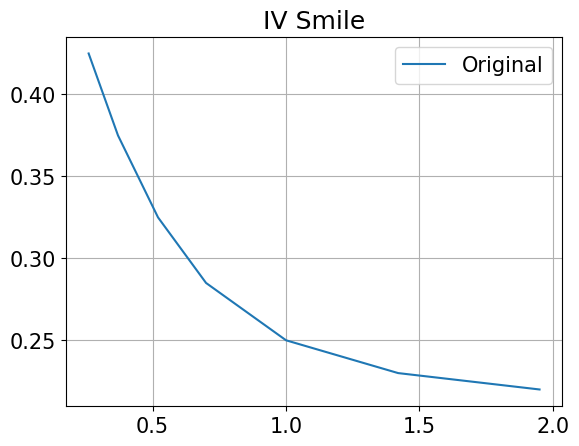

In [129]:
moneyness = np.array([0.26, 0.37, 0.52, 0.70, 1.00, 1.42, 1.95])
vols_iv   = np.array([0.425, 0.375, 0.325, 0.285, 0.25, 0.23, 0.22])


plt.plot(
    moneyness,
    vols_iv
)
plt.title('IV Smile')
plt.xlabel("")
plt.legend(["Original"])
plt.grid()
plt.show()

In [130]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float],
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))


def monotonicity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(len(c) - 1):
        if c[i + 1] >= c[i]:
            print("A monotonicity arbitrage was detected with strikes {} and {}".format(
                k[i], k[i+1]))
            arbitrage_detected = True

    if not arbitrage_detected:
        print("No arbitrage was detected.")


def convexity_arbitrage(c: np.ndarray, k: np.ndarray):
    arbitrage_detected = False
    for i in range(1, len(c) - 1):
        check_to = c[i-1] / (k[i] - k[i-1]) - c[i] * (1/(k[i] -
                                                         k[i-1]) + 1/(k[i+1] - k[i])) + c[i+1] / (k[i+1] - k[i])
        if check_to < 0:
            print("A convexity arbitrage was detected with strikes {}, {} and {}".format(
                k[i-1], k[i], k[i+1]))
            arbitrage_detected = True

    if not arbitrage_detected:
        print("No arbitrage was detected.")


def d_1_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_31 = - (f_3 - f_1) / (x_3 - x_1)
    return - (Delta_1 ** ((x_3 - x_1) / (x_3 - x_2))) * (Delta_31 ** (-(x_2 - x_1) / (x_3 - x_2)))


def d_approx(x_1: float, x_2: float, x_3: float, f_1: float, f_2: float, f_3: float):
    Delta_1 = - (f_2 - f_1) / (x_2 - x_1)
    Delta_2 = - (f_3 - f_2) / (x_3 - x_2)
    return - (Delta_1 ** ((x_3 - x_2) / (x_3 - x_1))) * (Delta_2 ** ((x_2 - x_1) / (x_3 - x_1)))


def d_n_approx(x_n_2: float, x_n_1: float, x_n: float, f_n_2: float, f_n_1: float, f_n: float):
    Delta_n_1 = - (f_n - f_n_1) / (x_n - x_n_1)
    Delta_nn_2 = - (f_n - f_n_2) / (x_n - x_n_2)
    return - (Delta_n_1 ** ((x_n - x_n_2) / (x_n_1 - x_n_2))) * (Delta_nn_2 ** (-(x_n - x_n_1) / (x_n_1 - x_n_2)))


def r_boundary(d: Iterable, f: Iterable, x: Iterable):
    r = []
    for i in range(len(x) - 1):
        Delta_i = (f[i + 1] - f[i]) / (x[i + 1] - x[i])
        r.append(max((d[i + 1] - d[i]) / (d[i + 1] - Delta_i),
                 (d[i + 1] - d[i]) / (Delta_i - d[i])))
    return r


def slopes_estimation(x: list, y: list):
    slopes = []
    for i in range(len(x)):
        if i == 0:
            slopes.append(d_1_approx(
                x_1=x[i], x_2=x[i+1], x_3=x[i+2], f_1=y[i], f_2=y[i+1], f_3=y[i+2]))
        elif i == len(x) - 1:
            slopes.append(d_n_approx(
                x_n_2=x[i-2], x_n_1=x[i-1], x_n=x[i], f_n_2=y[i-2], f_n_1=y[i-1], f_n=y[i]))
        else:
            slopes.append(
                d_approx(x_1=x[i-1], x_2=x[i], x_3=x[i+1], f_1=y[i-1], f_2=y[i], f_3=y[i+1]))

    return slopes


def breeden_litzenberger_density(f: Union[np.ndarray, float], df_dlogm: Union[np.ndarray, float], d2f_dlogm2: Union[np.ndarray, float],
                                 moneyness: Union[np.ndarray, float], forward: float):
    z = np.log(moneyness)
    zeta = z / np.sqrt(f) + np.sqrt(f) / 2
    K = moneyness * forward
    return norm.pdf(zeta) / (4 * K * np.sqrt(f)) * (2 * d2f_dlogm2 + (z * df_dlogm / f - 2) ** 2 - (df_dlogm) ** 2 * (1 / 4 + 1 / f))


class RationalCubicSplineInterpolator:
    def __init__(self, x, y, r, d):
        self._rationa_cubic_splines = []
        self.x = x
        for i in range(len(x) - 1):
            x_l, x_r = x[i], x[i + 1]
            y_l, y_r = y[i], y[i + 1]
            r_i = r[i]
            d_l, d_r = d[i], d[i + 1]
            self._rationa_cubic_splines.append(self.P_over_Q(
                x_l=x_l, x_r=x_r, y_l=y_l, y_r=y_r, d_l=d_l, d_r=d_r, r=r_i))

    def __call__(self, x):
        if isinstance(x, float):
            x = [x]
        output = []
        for x_ in x:
            if self.x[0] > x_:
                output.append(self._rationa_cubic_splines[0](x_))
            if self.x[-1] <= x_:
                output.append(self._rationa_cubic_splines[-1](x_))
            for i in range(len(self.x) - 1):
                if self.x[i] <= x_ < self.x[i + 1]:
                    output.append(self._rationa_cubic_splines[i](x_))
        return np.array(output)

    def P_over_Q(self, x_l: float, x_r: float, y_l: float, y_r: float, d_l: float, d_r: float, r: float):
        return lambda x: self.P(x_l=x_l, x_r=x_r, f_l=y_l, f_r=y_r, d_l=d_l, d_r=d_r, r=r)(x) / self.Q(x_l=x_l, x_r=x_r, r=r)(x)

    def P(self, x_l: float, x_r: float, f_l: float, f_r: float, d_l: float, d_r: float, r: float):
        h = (x_r - x_l)
        def theta(x): return (x - x_l) / h
        return lambda x: f_r * (theta(x))**3 + (r * f_r - h * d_r) * (theta(x))**2 * (1 - theta(x)) + \
            (r * f_l + h * d_l) * (theta(x)) * \
            (1 - theta(x))**2 + f_l * (1 - theta(x))**3

    def Q(self, x_l: float, x_r: float, r: float):
        h = (x_r - x_l)
        def theta(x): return (x - x_l) / h
        return lambda x: 1 + (r - 3) * theta(x) * (1 - theta(x))


def implied_volatility(prices: Union[np.ndarray, float], T: float, K: Union[np.ndarray, float],
                       forward: float, type="calls", df: float = 1.0, r: float = 0.0):
    if isinstance(K, float):
        flags = 'c' if K > forward else 'p'

    elif isinstance(K, np.ndarray):
        calls_indicators = (K[:-1] + K[1:]) * 0.5 >= 1
        calls_indicators = np.append(calls_indicators, True)
        thetas = 2 * calls_indicators - 1
        flags = np.vectorize(lambda x: "c" if x == 1.0 else "p")(thetas)
        if type == "calls":
            prices[~calls_indicators] = prices[~calls_indicators] - \
                df * (forward - K[~calls_indicators])
        elif type == 'puts':
            prices[calls_indicators] = prices[calls_indicators] + \
                df * (forward - K)

    return implied_volatility_vectorized(price=prices, S=forward, K=K,
                                         t=T, r=r, flag=flags)

Строим кубический сплайн $S_3(x)$, который на каждом элементарном отрезке $[x_i, x_{i+1}]$ является полиномом третьей степени. 


Сплайн должен удовлетворять следующим условиям:   
Интерполяция значений: $S_3(x_i) = f_i$.   
Непрерывность первых производных: $S_3'(x_i) = m_i$, где $m_i$ — первые производные (наклоны).   
Гладкость класса $C^2$:  
Вторая производная сплайна должна быть непрерывна во всех внутренних узлах:
$$
S_3''(x_i - 0) = S_3''(x_i + 0)
$$
2. Представление в форме ЭрмитаНа интервале $[x_i, x_{i+1}]$ полином удобно представить через локальную переменную $t = \frac{x - x_i}{h_i}$, где $h_i = x_{i+1} - x_i$ и $t \in [0, 1]$.Общий вид полинома через базисные функции Эрмита:
$$
S_3(x) = H_{00}(t)f_i + H_{10}(t)h_i m_i + H_{01}(t)f_{i+1} + H_{11}(t)h_i m_{i+1}
$$
Где базисные полиномы определяются как:

$$H_{00}(x) = \frac{(x_{i+1} - x)^2 \left( h_i + 2(x - x_i) \right)}{h_i^3}$$

$$H_{10}(x) = \frac{(x - x_i)(x_{i+1} - x)^2}{h_i^2}$$

$$H_{01}(x) = \frac{(x - x_i)^2 \left( h_i + 2(x_{i+1} - x) \right)}{h_i^3}$$

$$H_{11}(x) = \frac{(x - x_i)^2(x - x_{i+1})}{h_i^2}$$

или в терминах t:

$H_{00}(t) = (1 + 2t)(1 - t)^2$ — вес для значения $f_i$.

$H_{10}(t) = t(1 - t)^2$ — вес для наклона $m_i$.

$H_{01}(t) = t^2(3 - 2t)$ — вес для значения $f_{i+1}$.

$H_{11}(t) = t^2(t - 1)$ — вес для наклона $m_{i+1}$.

Это представление гарантирует совпадение значений $f_i$ и производных $m_i$ на концах отрезка.
3. Вывод уравнения для наклонов ($m$)Для обеспечения непрерывности второй производной $S_3''(x)$ в узле $x_i$ используются значения с левого интервала $[x_{i-1}, x_i]$ и правого $[x_i, x_{i+1}]$:Слева (из $[x_{i-1}, x_i]$):
$$
S_3''(x_i) = \frac{2}{h_i} m_{i-1} + \frac{4}{h_i} m_i + \frac{6}{h_i^2} f_{i-1} - \frac{6}{h_i^2} f_i
$$
Справа (из $[x_i, x_{i+1}]$):
$$
S_3''(x_i) = -\frac{4}{h_{i+1}} m_i - \frac{2}{h_{i+1}} m_{i+1} - \frac{6}{h_{i+1}^2} f_i + \frac{6}{h_{i+1}^2} f_{i+1}
$$
Приравнивая их, получаем уравнение для трех последовательных наклонов $m_{i-1}, m_i, m_{i+1}$:
$$
\frac{1}{h_{i-1}} m_{i-1} + 2 \left( \frac{1}{h_{i-1}} + \frac{1}{h_i} \right) m_i + \frac{1}{h_i} m_{i+1} = 3 \frac{y_i - y_{i-1}}{h_{i-1}^2} + 3 \frac{y_{i+1} - y_i}{h_i^2}
$$
4. Система линейных уравнений и матричный вид. 
Для всех внутренних узлов уравнения формируют систему $A \vec{m} = \vec{B}$ с трехдиагональной матрицей $A$. 

Для каждой строки $i$: $A_i = \frac{1}{h_{i-1}}$ — коэффициент при $m_{i-1}$.$B_i = 2 \left( \frac{1}{h_{i-1}} + \frac{1}{h_i} \right)$ — коэффициент при $m_i$.$C_i = \frac{1}{h_i}$ — коэффициент при $m_{i+1}$.

5. Численное решение: Метод прогонки

Поскольку матрица $A$ трехдиагональная, система эффективно решается методом прогонки (алгоритм Томаса). Алгоритм включает два этапа:Прямой ход: вычисление прогоночных коэффициентов $\alpha_i$ и $\beta_i$:
$$\alpha_{i+1} = \frac{b_i}{c_i - a_i \alpha_i}, \quad \beta_{i+1} = \frac{f_i + a_i \beta_i}{c_i - a_i \alpha_i}$$
Обратный ход: нахождение искомых наклонов $m_i$ от $N$ к $0$.

In [131]:
class MyCubicSpline:
    def __init__(self, x_arr, y_arr, d=None):
        self.X = np.array(x_arr)
        self.F_vals = np.array(y_arr) # Значения функции в этих узлах
        self.N = len(self.X) - 1      # Количество интервалов между узлами
        self.H = np.diff(self.X)      # Массив шагов: h_i = x_{i+1} - x_i
        
        if d is not None:
            self.derivatives = np.array(d) # Если производные уже известны, просто сохраняем их
        else:
            self.F_vec = [0.0] * (self.N + 1)
            if self.N >= 1:
                # Граничные условия: оцениваем производную на концах через соседнюю точку
                # m_0 = (f_1 - f_0) / (x_1 - x_0)
                m0 = (self.F_vals[1] - self.F_vals[0]) / (self.X[1] - self.X[0])
                mN = (self.F_vals[self.N] - self.F_vals[self.N-1]) / (self.X[self.N] - self.X[self.N-1])
                self.F_vec[0] = m0
                for i in range(1, self.N): self.F_vec[i] = self.F_vals[i]
                self.F_vec[self.N] = mN
            
            B = self._createRightSide(self.H, self.F_vals)
            A = self._createMatrix(self.N, self.H)
            self.derivatives = self._solveTridiag(A, B)

    def _createRightSide(self, H, F):
        N = len(F) - 1; B = [0.0] * (N + 1)
        B[0] = self.F_vec[0]; B[N] = self.F_vec[self.N]
        for i in range(1, N):
            h_ = H[i-1]; h = H[i]
            B[i] = ( - 1.0/(h_*h_) * F[i-1] + (1.0/(h_*h_) - 1.0/(h*h)) * F[i] + 1.0/(h*h) * F[i+1] ) * 3.0 
        return B

    def _createMatrix(self, N, H):
        M = [[0.0]*(N+1) for _ in range(N+1)]
        for i in range(N+1):  
            if i == 0: M[0][0] = 1.0
            elif i == N: M[N][N] = 1.0 
            else:
                h_ = H[i-1]; h = H[i]         
                M[i][i-1] = 1.0/h_; M[i][i] = 2.0/h_ + 2.0/h; M[i][i+1] = 1.0/h 
        return M

    def _solveTridiag(self, M, f):
        N = len(f) - 1
        alpha = [0.0]*(N+1); beta = [0.0]*(N+1); y = [0.0]*(N+1)
        a = [0.0]*(N+1); b = [0.0]*(N+1); c = [0.0]*(N+1)
        for i in range(N+1):
            c[i] = M[i][i]
            if i > 0 and i < N: a[i] = -1.0*M[i][i-1]; b[i] = -1.0*M[i][i+1]
        
        alpha[1] = b[0]/c[0]; beta[1] = f[0]/c[0]
        for i in range(1, N):
            denom = c[i] - a[i]*alpha[i]
            alpha[i+1] = b[i]/denom; beta[i+1] = (f[i] + a[i]*beta[i])/denom
        denom = c[N] - a[N]*alpha[N]
        y[N] = (f[N] + a[N]*beta[N])/denom
        for i in range(N-1, -1, -1): y[i] = alpha[i+1]*y[i+1] + beta[i+1]
        return y

    def _buildSplineVal(self, x, i):
        xi_ = self.X[i]; xi = self.X[i+1]; h = xi - xi_    
        m_ = self.derivatives[i]; m = self.derivatives[i+1]    
        fi_ = self.F_vals[i]; fi = self.F_vals[i+1]  # Значения на краях
        t = (x - xi_) / h
        h00 = (1 + 2*t) * (1 - t)**2
        h10 = t * (1 - t)**2
        h01 = t**2 * (3 - 2*t)
        h11 = t**2 * (t - 1)
        return h00*fi_ + h10*h*m_ + h01*fi + h11*h*m

    def _buildSplineDerivative(self, x, i, nu=1):
        xi_ = self.X[i]; xi = self.X[i+1]; h = xi - xi_
        m_ = self.derivatives[i]; m = self.derivatives[i+1]
        fi_ = self.F_vals[i]; fi = self.F_vals[i+1]
        t = (x - xi_) / h
        if nu == 1:
            val = (fi_ * 6*t*(t-1) + fi * (-6*t*(t-1)) + m_ * h * (1 - 4*t + 3*t*t) + m * h * (3*t*t - 2*t))
            return val / h
        elif nu == 2:
            val = (fi_ * (12*t - 6) + fi * (6 - 12*t) + m_ * h * (6*t - 4) + m * h * (6*t - 2))
            return val / (h*h)
        return 0.0

    def __call__(self, x_eval):
        """Позволяет вызывать объект как функцию: cs(x)"""
        x_eval = np.atleast_1d(x_eval)
        res = np.zeros_like(x_eval, dtype=float)
        for k, val in enumerate(x_eval):
            if val <= self.X[0]: idx = 0
            elif val >= self.X[-1]: idx = self.N - 1
            else: idx = np.searchsorted(self.X, val) - 1
            
            idx = max(0, min(self.N - 1, idx))
            res[k] = self._buildSplineVal(val, idx)
        return res

    def derivative(self, x, nu=1):
        """Вычисляет аналитическую производную порядка nu (1 или 2)"""
        x_eval = np.atleast_1d(x)
        res = np.zeros_like(x_eval, dtype=float)
        for k, val in enumerate(x_eval):
            if val <= self.X[0]: idx = 0
            elif val >= self.X[-1]: idx = self.N - 1
            else: idx = np.searchsorted(self.X, val) - 1
            
            idx = max(0, min(self.N - 1, idx))
            res[k] = self._buildSplineDerivative(val, idx, nu=nu)
        return res
 

In [132]:
forward, df, T = 1.0, 1.0, 1.0
calls_wide_range = black(log_moneyness=np.log(moneyness),
                         forward=forward,
                         vol=vols_iv,
                         df=df, T=T, theta=1)

dense_grid = np.linspace(moneyness[0], moneyness[-1], 50)
dense_grid = np.unique(np.append(dense_grid, moneyness[:-1]))

<>:22: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:24: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:26: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:30: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:31: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:22: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:24: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences wil

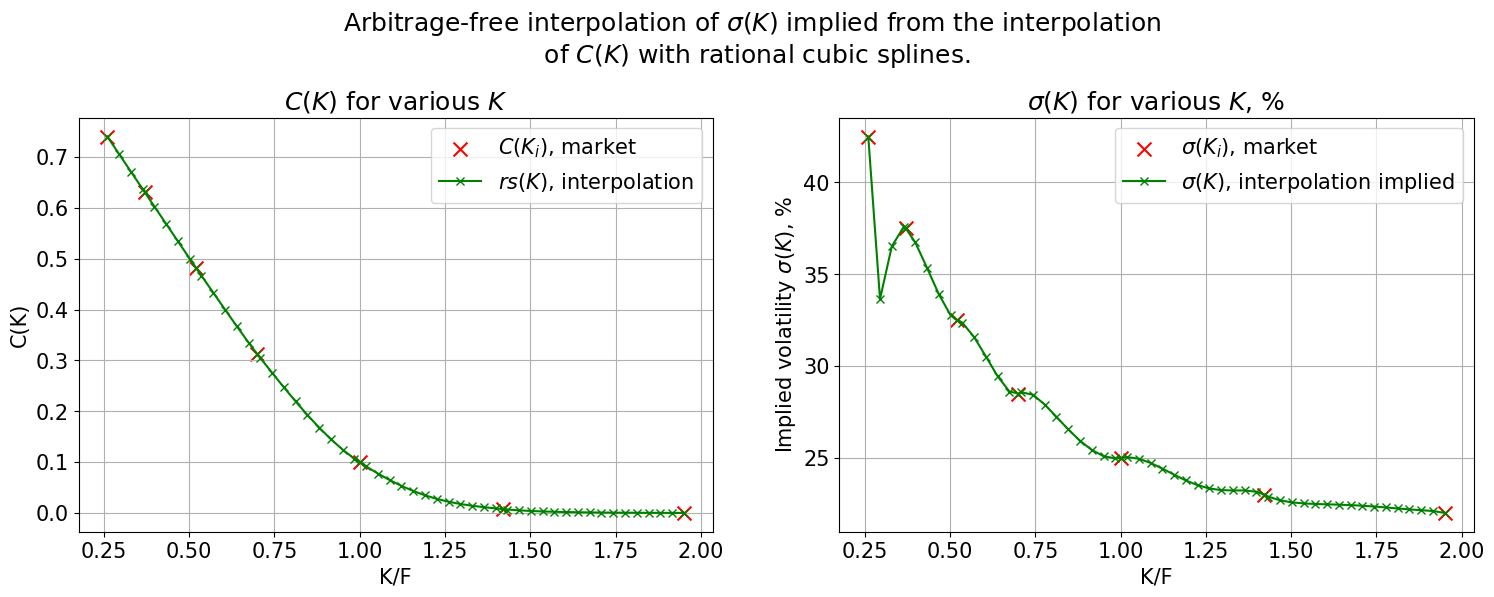

In [133]:
calls_slopes = slopes_estimation(x=moneyness, y=calls_wide_range)
r = r_boundary(d=calls_slopes, f=calls_wide_range, x=moneyness)

interpolated_calls_rs = RationalCubicSplineInterpolator(
    x=moneyness, y=calls_wide_range, r=r, d=calls_slopes
)

implied_vols_via_rs_prices_interpolation = implied_volatility(
    prices=interpolated_calls_rs(dense_grid),
    T=T, K=dense_grid * forward,
    forward=forward, type="calls", df=df
)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
plt.rcParams.update({'font.size': 15, "axes.labelsize": 15})

ax[0].scatter(moneyness, calls_wide_range,
              label="$C(K_i)$, market", marker="x", color="red", s=100)
ax[0].plot(dense_grid, interpolated_calls_rs(dense_grid),
           label="$rs(K)$, interpolation", marker="x", color="green")
ax[1].scatter(moneyness, vols_iv * 100,
              label="$\sigma(K_i)$, market", marker="x", color="red", s=100)
ax[1].plot(dense_grid, implied_vols_via_rs_prices_interpolation * 100,
           label="$\sigma(K)$, interpolation implied", marker="x", color="green")

plt.suptitle("Arbitrage-free interpolation of $\sigma(K)$ implied from the interpolation \n of $C(K)$ with rational cubic splines.")
plt.subplots_adjust(top=0.8)
ax[0].set_title('$C(K)$ for various $K$'), ax[0].set_xlabel(
    'K/F'), ax[0].set_ylabel('C(K)'), ax[0].legend()
ax[1].set_title('$\sigma(K)$ for various $K$, %'), ax[1].set_xlabel(
    'K/F'), ax[1].set_ylabel('Implied volatility $\sigma(K)$, %'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

# print("Проверка монотонности")
# monotonicity_arbitrage(c=interpolated_calls_rs, k=dense_grid * forward)

# print("\nПроверка выпуклости")
# convexity_arbitrage(c=interpolated_calls_rs, k=dense_grid * forward)

In [134]:
prices_array = interpolated_calls_rs(dense_grid)

strikes_array = dense_grid * forward

print("Проверка монотонности (C' < 0):")
monotonicity_arbitrage(c=prices_array, k=strikes_array)

print("\nПроверка выпуклости (Butterfly, C'' > 0):")
convexity_arbitrage(c=prices_array, k=strikes_array)

Проверка монотонности (C' < 0):
No arbitrage was detected.

Проверка выпуклости (Butterfly, C'' > 0):
No arbitrage was detected.


In [135]:
def breeden_litzenberger_density(f: Union[np.ndarray, float], df_dlogm: Union[np.ndarray, float], d2f_dlogm2: Union[np.ndarray, float],
                                 moneyness: Union[np.ndarray, float], forward: float):
    z = np.log(moneyness)
    zeta = z / np.sqrt(f) + np.sqrt(f) / 2
    K = moneyness * forward
    return norm.pdf(zeta) / (4 * K * np.sqrt(f)) * (2 * d2f_dlogm2 + (z * df_dlogm / f - 2) ** 2 - (df_dlogm) ** 2 * (1 / 4 + 1 / f))


# def check_arbitrage(prices, strikes):
#     """Checks for monotonicity and butterfly arbitrage in price array."""
#     mono_arb = False
#     for i in range(len(prices) - 1):
#         if prices[i+1] >= prices[i]: 
#             mono_arb = True
#             break
            
#     conv_arb = False
#     for i in range(1, len(prices) - 1):
#         k_l, k_c, k_r = strikes[i-1], strikes[i], strikes[i+1]
#         c_l, c_c, c_r = prices[i-1], prices[i], prices[i+1]
        
#         term1 = c_l / (k_c - k_l)
#         term2 = c_c * (1/(k_c - k_l) + 1/(k_r - k_c))
#         term3 = c_r / (k_r - k_c)
#         butterfly = term1 - term2 + term3
        
#         if butterfly < -1e-9: 
#             conv_arb = True
            
#     return mono_arb, conv_arb

moneyness = np.array([0.26, 0.37, 0.52, 0.70, 1.00, 1.42, 1.95])
vols_iv = np.array([0.425, 0.375, 0.325, 0.285, 0.25, 0.23, 0.22])
log_moneyness = np.log(moneyness)
T = 1.0
forward = 1.0

cs = MyCubicSpline(log_moneyness, vols_iv)

dense_k = np.linspace(moneyness[0], moneyness[-1], 200)
dense_z = np.log(dense_k)

interp_vol = cs(dense_z)
dvol_dz = cs.derivative(dense_z, nu=1)
d2vol_dz2 = cs.derivative(dense_z, nu=2)

# f = sigma^2 * T
# f' = 2 * sigma * sigma' * T
# f'' = 2 * ( (sigma')^2 + sigma * sigma'' ) * T
w = interp_vol**2 * T
dw_dz = 2 * interp_vol * dvol_dz * T
d2w_dz2 = 2 * (dvol_dz**2 + interp_vol * d2vol_dz2) * T


Проверка монотонности
No arbitrage was detected.

Проверка выпуклости
No arbitrage was detected.


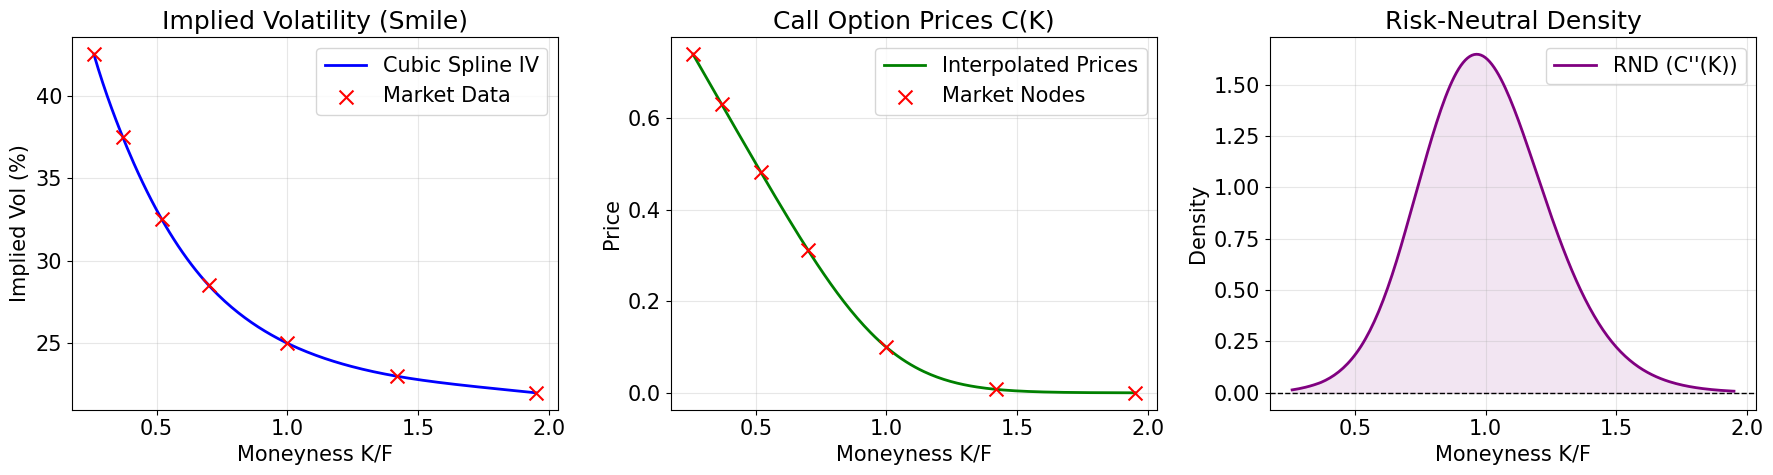

In [146]:
prices = black(dense_z, forward, interp_vol, T=T)

prices_nodes = black(log_moneyness, forward, vols_iv, T=T)

density = breeden_litzenberger_density(w, dw_dz, d2w_dz2, dense_k, forward)

neg_density = np.any(density < 0)


strikes = dense_k * forward 

print("Проверка монотонности")
monotonicity_arbitrage(c=prices, k=strikes)

print("\nПроверка выпуклости")
convexity_arbitrage(c=prices, k=strikes)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Интерполяция волатильности
axs[0].plot(dense_k, interp_vol * 100, label='Cubic Spline IV', color='blue', linewidth=2)
axs[0].scatter(moneyness, vols_iv * 100, color='red', marker='x', s=100, label='Market Data', zorder=5)
axs[0].set_title('Implied Volatility (Smile)')
axs[0].set_xlabel('Moneyness K/F')
axs[0].set_ylabel('Implied Vol (%)')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Цены опционов Call
axs[1].plot(dense_k, prices, label='Interpolated Prices', color='green', linewidth=2)
axs[1].scatter(moneyness, prices_nodes, marker='x', color='red', s=100, label='Market Nodes', zorder=5)
axs[1].set_title('Call Option Prices C(K)')
axs[1].set_xlabel('Moneyness K/F')
axs[1].set_ylabel('Price')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Риск-нейтральная плотность (Breeden-Litzenberger)
axs[2].plot(dense_k, density, label='RND (C\'\'(K))', color='purple', linewidth=2)
axs[2].axhline(0, color='black', linestyle='--', linewidth=1) # Линия нуля
axs[2].set_title('Risk-Neutral Density')
axs[2].set_xlabel('Moneyness K/F')
axs[2].set_ylabel('Density')
axs[2].fill_between(dense_k, 0, density, color='purple', alpha=0.1) 
axs[2].legend()
axs[2].grid(True, alpha=0.3)
# axs[2].set_ylim(0,0.1)

plt.tight_layout()
plt.show()




Your task is to price European/American options within finite-differencing approach. You may assume you are given an implied volatilities (together with your interplation method) from the previous task. 

1. Price within a finite-differencing method a European put option with strike $K=52\%$ and a European call option with strike $K = 130\%$. Use any numerical scheme you wish. Compare your results with the ones obtained analytically from Black-Scholes formula. How your results differ from the analytic ones? 

2. Price within a finite-differencing method an American put option with strike $K=52\%$. Please note that an American option can be exercised at any time before the maturity if its intrinsic value is greater than calculated option price at that step. Use any numerical scheme you wish. Please describe the way how option's "American" property affects your finite-differencing algorithm when you are stepping in time. How its price differs from the price of European option with the same strike? Why? 

You may use your own implementation of finite differencing algorithm or the one presented on the seminar.

In [137]:
from scipy.sparse.linalg import splu, spsolve
from scipy.sparse import csc_matrix

sys.path.append("part 3")
from pde_solver import solve_1d_pde, FiniteDifferencingScheme
from pricer import price, OptionType

In [138]:
def black(log_moneyness: Union[float, np.ndarray], forward: float, vol: Union[np.ndarray, float], 
          df: float = 1, T: float = 1, theta: float = 1) -> Union[float, np.ndarray]:
    total_vol = vol * np.sqrt(T)
    d_1 = - theta * (log_moneyness / total_vol - total_vol / 2)
    d_2 = - theta * (log_moneyness / total_vol + total_vol / 2)   
    return df * theta * forward * (norm.cdf(d_1) - np.exp(log_moneyness) * norm.cdf(d_2))


In [139]:
number_of_spatial_levels, number_of_time_steps = 101, 51
t_start, t_end = 0, 1
x_min, x_max = -1, 1
terminal_condition = np.vectorize(lambda x: 0.0)
sigma = 0.2
pde_coefficients = lambda _:  {"U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}

number_of_time_steps = 31
finite_differencing_spacial_levels = 51
number_of_std_deviations = 4
scheme_type = FiniteDifferencingScheme.Implicit

In [140]:
spot = 1.
r, sigma = 0.16, 0.2
# maturities = np.array([1/12, 3/12, 6/12, 1])
maturities = np.array([1])
strikes = np.linspace(spot * 0.52, spot * 1.3)
trade_values_calls = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_calls_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))
trade_values_puts_analytic = np.zeros((maturities.shape[0], strikes.shape[0]))

for i, maturity in enumerate(maturities):
    for j, strike in enumerate(strikes):
        trade_values_calls[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.CALL,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
        
        trade_values_calls_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot * np.exp(r * maturity),
                                                  vol=sigma,
                                                  df = np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=1)
        
        trade_values_puts[i][j] = price(maturity=maturity, strike=strike, option_type=OptionType.PUT,
                                         number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                                         pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot,
                                         volatility=sigma, interest_rate=r, number_of_std_deviations=number_of_std_deviations)
        
        trade_values_puts_analytic[i][j] = black(log_moneyness=np.log(strike / (spot * np.exp(r * maturity))),
                                                  forward=spot * np.exp(r * maturity),
                                                  vol=sigma,
                                                  df = np.exp(-r * maturity),
                                                  T=maturity,
                                                  theta=-1)

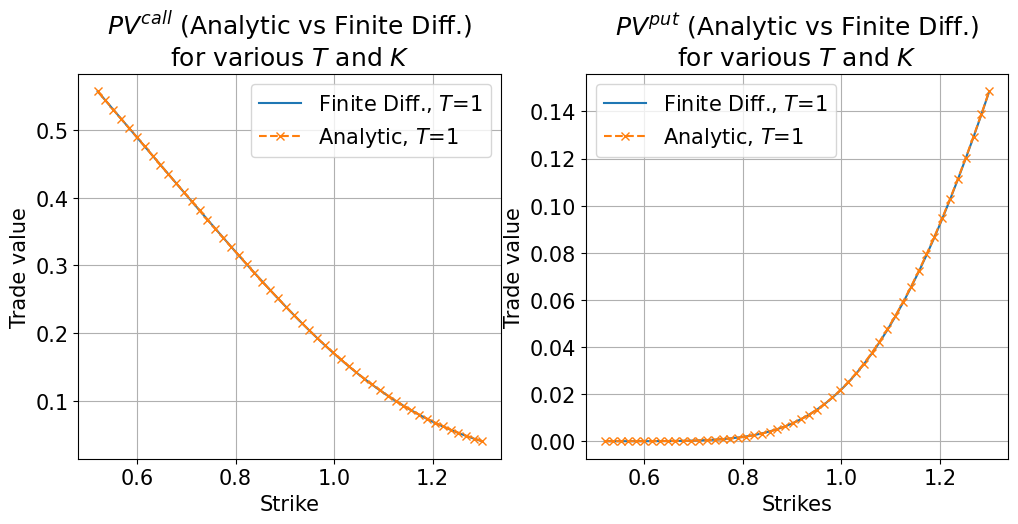

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, _ in enumerate(maturities):
    ax[0].plot(strikes, trade_values_calls[i], label="Finite Diff., $T$={}".format(round(maturities[i], 2)), linestyle="-")
    ax[0].plot(strikes, trade_values_calls_analytic[i], label="Analytic, $T$={}".format(round(maturities[i], 2)), linestyle="--", marker="x")

    ax[1].plot(strikes, trade_values_puts[i], label="Finite Diff., $T$={}".format(round(maturities[i], 2)), linestyle="-")
    ax[1].plot(strikes, trade_values_puts_analytic[i], label="Analytic, $T$={}".format(round(maturities[i], 2)), linestyle="--", marker="x")

ax[0].set_title('$PV^{call}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$'), ax[0].set_xlabel('Strike'), ax[0].set_ylabel('Trade value'), ax[0].legend()
ax[1].set_title('$PV^{put}$ (Analytic vs Finite Diff.)\n' + 'for various $T$ and $K$'), ax[1].set_xlabel('Strikes'), ax[1].set_ylabel('Trade value'), ax[1].legend()
ax[0].grid(), ax[1].grid()
plt.show()

In [142]:

print(f"euro_call with K = 130%: {trade_values_calls[0][1]}")
print(f"euro_put  with K = 52%: {trade_values_puts[0][0]}")
      
print("delta of Finite diff and analytical solution for euro_call: ", f"{abs(trade_values_calls_analytic[0][1] - trade_values_calls[0][1]):e}")
print("delta of Finite diff and analytical solution for euro_put: ", f"{abs(trade_values_puts_analytic[0][0] - trade_values_puts[0][0]):e}")


euro_call with K = 130%: 0.5433297283878885
euro_put  with K = 52%: 1.872509309432824e-07
delta of Finite diff and analytical solution for euro_call:  7.863248e-06
delta of Finite diff and analytical solution for euro_put:  5.066804e-07


In [143]:
import scipy.interpolate

k_call_target = spot * 1.30
k_put_target = spot * 0.52

# Считаем точечно для точности (так как в массиве strikes может не быть ровно 0.52)
val_call_fd = price(maturity=1.0, strike=k_call_target, option_type=OptionType.CALL,
                    number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                    pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot, volatility=sigma, interest_rate=r)
val_call_an = black(log_moneyness=np.log(k_call_target / (spot * np.exp(r * 1.0))), forward=spot * np.exp(r * 1.0), vol=sigma, df=np.exp(-r * 1.0), T=1.0, theta=1)

val_put_fd = price(maturity=1.0, strike=k_put_target, option_type=OptionType.PUT,
                   number_of_spatial_levels=number_of_spatial_levels, number_of_time_steps=number_of_time_steps,
                   pde_coefficients=pde_coefficients, scheme=scheme_type, spot=spot, volatility=sigma, interest_rate=r)
val_put_an = black(log_moneyness=np.log(k_put_target / (spot * np.exp(r * 1.0))), forward=spot * np.exp(r * 1.0), vol=sigma, df=np.exp(-r * 1.0), T=1.0, theta=-1)

print("-" * 50)
print(f"Euro Call (K=1.3): {val_call_fd:.6e} | Analytic: {val_call_an:.6e}")
print(f"Euro Put  (K=0.52): {val_put_fd:.6e} | Analytic: {val_put_an:.6e}")
print(f"Delta Call: {abs(val_call_fd - val_call_an):.6e}")
print(f"Delta Put:  {abs(val_put_fd - val_put_an):.6e}")
print("-" * 50)



--------------------------------------------------
Euro Call (K=1.3): 4.063891e-02 | Analytic: 4.076938e-02
Euro Put  (K=0.52): 1.872509e-07 | Analytic: 6.939313e-07
Delta Call: 1.304699e-04
Delta Put:  5.066804e-07
--------------------------------------------------


In [144]:
spot = 1.0
sigma = 0.2
maturity = 1.0

k_put = 0.52 * spot
k_call = 1.30 * spot

n_space = 201
n_time = 201
n_std = 4
pde_coeffs = lambda _: {"U": 0, "U_t": 1., "U_x": 0, "U_xx": 0.5 * sigma ** 2}

rates = [0.12, 0.0, -0.05]  # >0, =0, <0

print(f"{'Rate':^8} | {'Option':^8} | {'Strike':^8} | {'Euro Price':^12} | {'Amer Price':^12} | {'Diff (A-E)':^12}")
print("-" * 75)

for r in rates:
    # European Put Option (K=52%)
    euro_put = price(maturity, k_put, OptionType.PUT, n_space, n_time, pde_coeffs, 
                     FiniteDifferencingScheme.Implicit, spot, sigma, r, n_std)
    
    # American
    amer_put = price(maturity, k_put, OptionType.PUT, n_space, n_time, pde_coeffs, 
                     FiniteDifferencingScheme.AmericanPut, spot, sigma, r, n_std)
    
    print(f"{r:^8.2f} | {'Put':^8} | {k_put:^8.2f} | {euro_put:^12.6e} | {amer_put:^12.6e} | {(amer_put - euro_put):^12.6e}")

    # European Call Option (K=130%)
    euro_call = price(maturity, k_call, OptionType.CALL, n_space, n_time, pde_coeffs, 
                      FiniteDifferencingScheme.Implicit, spot, sigma, r, n_std)
    
    print(f"{r:^8.2f} | {'Call':^8} | {k_call:^8.2f} | {euro_call:^12.6e} | {' ':^12} | {' ':^12}")
    print("-" * 75)

print("\n Американский Call при r >= 0 теоретически равен Европейскому.")

  Rate   |  Option  |  Strike  |  Euro Price  |  Amer Price  |  Diff (A-E) 
---------------------------------------------------------------------------
  0.12   |   Put    |   0.52   | 1.672760e-06 | 1.462263e-05 | 1.294987e-05
  0.12   |   Call   |   1.30   | 2.998541e-02 |              |             
---------------------------------------------------------------------------
  0.00   |   Put    |   0.52   | 2.208716e-05 | 2.208716e-05 | 0.000000e+00
  0.00   |   Call   |   1.30   | 1.012487e-02 |              |             
---------------------------------------------------------------------------
 -0.05   |   Put    |   0.52   | 5.537027e-05 | 5.537027e-05 | 0.000000e+00
 -0.05   |   Call   |   1.30   | 5.963114e-03 |              |             
---------------------------------------------------------------------------

 Американский Call при r >= 0 теоретически равен Европейскому.
